TokaMaker Example: NSTX-U Shape Generator and Control Point Selector
==========
In this example we demonstrate:
1. How to solve an inverse equilibrium problem to identify plasma scenarios which could be produced in NSTX-U subject to the power supply current limits
2. How to identify points on the plasma boundary which could be used as control points for the ISOFLUX shape control algorithm

**Note:** Running this example requires the following python packages must be installed (Python 3.11 required due to `omfit_classes` limitation):
```text
numpy matplotlib scipy h5py shapely omfit_classes   # Base requirements
uncertainties netCDF4 omas tqdm fortranformat       # OMFIT dependencies requirements
```

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from omfit_classes.omfit_eqdsk import boundaryShape
from shapely.geometry import Point, Polygon
from math import isinf
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [4]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
    
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun

## Setup NSTX-U Model

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [6]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          77e67da
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/h2/q90by53j4jg2k26dxj75pxqw0_x41g/T/oft_27712/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the NSTX-U mesh using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [8]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('NSTXU_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1.0*0.85)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.160E+01
    # of points  =   16122
    # of edges   =   48259
    # of cells   =   32138
    # of boundary points =     104
    # of boundary edges  =     104
    # of boundary cells  =     104
  Resolution statistics:
    hmin =  1.296E-03
    hrms =  3.105E-02
    hmax =  1.978E-01
  Surface grounded at vertex    5697


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    8.5099999999999998E-004


### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". Each NSTX-U coil has a maximum current magnitude of 24 kA. Some coils have a bipolar power supply, allowing both positive and negative currents, while some coils have a unipolar power supply allowing current in only one direction. The central solenoid current is ramped throughout a plasma discharge, so the current can be constrained here to mimic a particular point in the discharge.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [10]:
coil_bounds = {key: [-24.E3, 24.E3] for key in mygs.coil_sets}
coil_bounds['PF1AU'][0] = 0 # Unipolar, positive current
coil_bounds['PF1AL'][0] = 0 # Unipolar, positive current
coil_bounds['PF2U'][0] = 0 # Unipolar, positive current
coil_bounds['PF2L'][0] = 0 # Unipolar, positive current
coil_bounds['PF4'][1] = 0 # Unipolar, negative current
coil_bounds['PF5'][1] = 0 # Unipolar, negative current

# In a plasma pulse the OH current is ramped over time. Constraining The OH current can be constrained to 
coil_bounds['CS'][0] = 18.0E3; coil_bounds['CS'][1] = 18.0E3 + 1

mygs.set_coil_bounds(coil_bounds)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the coils. In TokaMaker these regularization terms have the general form, where each term corresponds to a set of coil coefficients, target value, and weight. The \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_reg_term "coil_reg_term()" method is provided to aid in defining these terms.

Below we apply a simple set of constraints to the coils.

In [12]:
# Set regularization weights
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,), dtype=np.float64)

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights)

## Solve Inverse Equilibrium Problem

### Define flux functions
The F\*F' and P' terms in the Grad-Shafranov equation must be pre-defined in order to solve the inverse equilibrium problem. A second-order polynomial is used in the NSTX-U EFIT01 reconstructions, and accordingly that convention is used here with example coefficients. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

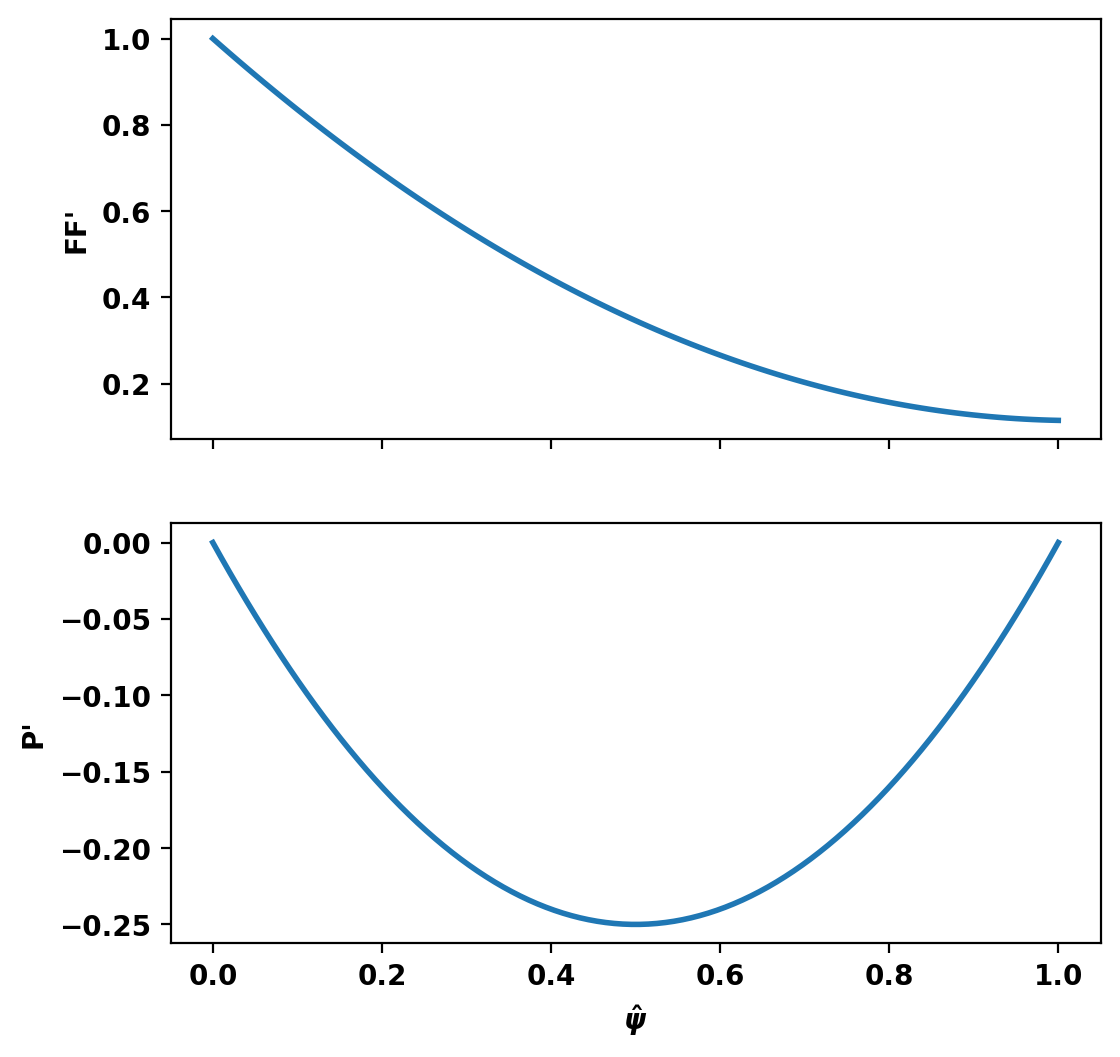

In [15]:
# Set profiles
x = np.linspace(0,1,100)
ffp_prof = {'type': 'linterp', 'x': x, 'y': 0.845*x*x - 1.73*x + 1}
pp_prof = {'type': 'linterp', 'x': x, 'y': x*(x-1)}

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the plasma pressure on-axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [17]:
Ip_target = 1.E6 # [A]
pax_target = 20.E3 # [Pa]
mygs.set_targets(Ip=Ip_target,pax=pax_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the same flux surface, approximately defining the overall plasma shape. Additionally, we define two X-points and set them as saddle constraints.

In [19]:
# Target shape parameters
null_type = 'LSN' # DN, USN, LSN, LIM
N_points = 10
R0_target = 0.95
Z0_target = -0.001
a_target = 0.55
kappa_upper_target = 2.0
kappa_lower_target = 2.4
delta_upper_target = 0.6
delta_lower_target = 0.6
zeta_upper_outer_target = 0
zeta_lower_outer_target = 0
zeta_upper_inner_target = 0
zeta_lower_inner_target = 0

# Select nulls
if(null_type == 'DN'):
    upnull_flag = True
    lonull_flag = True
elif(null_type == 'LSN'):
    upnull_flag = False
    lonull_flag = True
elif(null_type == 'USN'):
    upnull_flag = True
    lonull_flag = False
else:
    upnull_flag = False
    lonull_flag = False
            
# Use the OMFIT boundary shape generator to include x-points
R_ISO, Z_ISO, Z_ref = boundaryShape(
        a=a_target,
        eps=a_target/R0_target,
        kapu=kappa_upper_target,
        kapl=kappa_lower_target,
        delu=delta_upper_target,
        dell=delta_lower_target,
        zetaou=zeta_upper_outer_target,
        zetaiu=zeta_upper_inner_target,
        zetail=zeta_lower_inner_target,
        zetaol=zeta_lower_outer_target,
        zoffset=Z0_target,
        doPlot=False,
        npts=N_points,
        upnull=upnull_flag,
        lonull=lonull_flag
    )
isoflux_pts = np.transpose(np.array([R_ISO, Z_ISO]))

# Set isoflux constraint for TokaMaker
mygs.set_isoflux(isoflux_pts)

# Find the x-points

# Highest point
Z_top = isoflux_pts[:,1].max()
R_top = isoflux_pts[np.argmax(isoflux_pts[:,1]), 0]

# Lowest point
Z_bot = isoflux_pts[:,1].min()
R_bot = isoflux_pts[np.argmin(isoflux_pts[:,1]), 0]

# Select nulls
if(null_type == 'DN'):
    x_points = np.array([(R_bot, Z_bot), (R_top, Z_top)])
elif(null_type == 'LSN'):
    x_points = np.array([(R_bot, Z_bot)])
elif(null_type == 'USN'):
    x_points = np.array([(R_top, Z_top)])
else:
    x_points = np.array([])

# Set x-point constraint for TokaMaker
mygs.set_saddles(x_points)

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified `Ip_target`, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [21]:
mygs.init_psi(0.90, 0, 0.55, 1.8, 0.6)
mygs.solve()

Starting non-linear GS solver
     1  7.2570E-01 -3.6867E+00  1.0644E-02  1.0765E+00 -4.1193E-02 -0.0000E+00
     2  1.5497E+00 -2.1079E+00  2.6600E-03  1.0363E+00 -2.7592E-02 -0.0000E+00
     3  1.7338E+00 -1.8160E+00  1.5357E-03  1.0319E+00 -2.8039E-02 -0.0000E+00
     4  1.8562E+00 -1.6948E+00  9.7283E-04  1.0297E+00 -2.8459E-02 -0.0000E+00
     5  1.9317E+00 -1.6351E+00  6.3091E-04  1.0284E+00 -2.8638E-02 -0.0000E+00
     6  1.9775E+00 -1.6022E+00  3.8469E-04  1.0276E+00 -2.8692E-02 -0.0000E+00
     7  2.0066E+00 -1.5834E+00  2.5391E-04  1.0271E+00 -2.8680E-02 -0.0000E+00
     8  2.0240E+00 -1.5718E+00  1.5388E-04  1.0267E+00 -2.8647E-02 -0.0000E+00
     9  2.0339E+00 -1.5647E+00  9.1377E-05  1.0265E+00 -2.8613E-02 -0.0000E+00
    10  2.0398E+00 -1.5609E+00  8.2234E-05  1.0264E+00 -2.8578E-02 -0.0000E+00
    11  2.0436E+00 -1.5587E+00  5.4992E-05  1.0264E+00 -2.8549E-02 -0.0000E+00
    12  2.0458E+00 -1.5573E+00  2.5435E-05  1.0263E+00 -2.8525E-02 -0.0000E+00
    13  2.0472E+00 -1.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

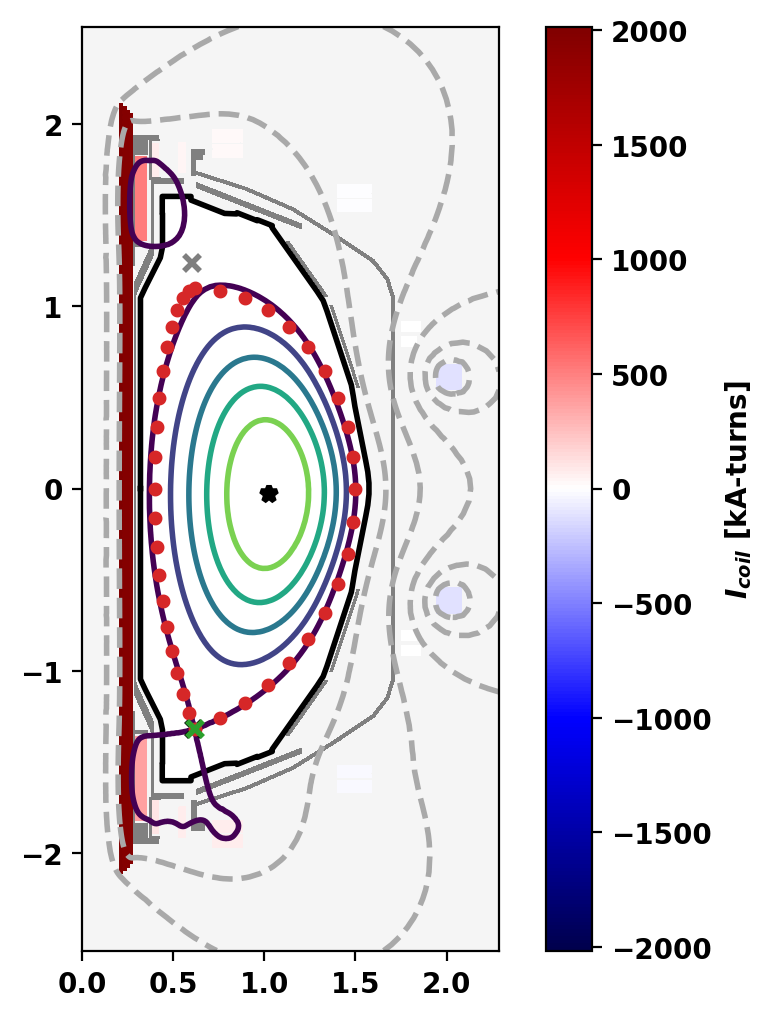

In [23]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA-turns]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=6,plasma_nlevels=6)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

### Print out info about coil currents and the plasma equilibrium

In [25]:
eig_vals, eig_vecs = mygs.eig_td(-37.5*100.0,5,include_bounds=False)
if(isinf(eig_vals[0,0])):
    print('Vertically Unstable in the Ideal-Wall Limit')
else:
    print('Vertical Instability Growth Rate [1/s]: ', np.floor(-eig_vals[0,0]))

coil_currents = mygs.get_coil_currents()[0]
for coil in coil_currents:
    print(f"{coil:6s}: {coil_currents[coil]/1.E3:+7.3f} kA")

mygs.print_info()

Vertical Instability Growth Rate [1/s]:  363.0
CS    : +18.000 kA
PF1AU :  +8.047 kA
PF1BU :  +2.212 kA
PF1CU :  +1.862 kA
PF2U  :  +2.071 kA
PF3U  :  -0.034 kA
PF4   :  +0.000 kA
PF5   :  -9.854 kA
PF3L  :  -1.603 kA
PF2L  :  +4.979 kA
PF1CL :  +3.417 kA
PF1BL :  +3.437 kA
PF1AL :  +5.902 kA
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    0.926 -0.042
  Magnetic Axis [m]       =    1.026 -0.028
  Elongation              =    2.153 (U:  2.021, L:  2.284)
  Triangularity           =    0.436 (U:  0.305, L:  0.566)
  Plasma Volume [m^3]     =   11.332
  q_0, q_95               =    2.021  7.632
  Peak Pressure [Pa]      =    2.0000E+04
  Stored Energy [J]       =    1.4639E+05
  <Beta_pol> [%]          =   45.0919
  <Beta_tor> [%]          =    2.6227
  <Beta_n>   [%]          =    1.3491
  Diamagnetic flux [Wb]   =    2.6216E-02
  Toroidal flux [Wb]      =    2.1628E+00
  l_i                     =   

## Find control points for ISOFLUX shape control algorithm

The ISOFLUX shape control algorithm monitors the poloidal flux at a set of user-defined locations and adjusts the coil currents until the poloidal flux at each control point matches the flux at the x-point. The process of selecting the control points for a given target boundary shape is partially automated by defining several "control segments". The control points are simply the intersection between the pre-defined control segments and the target boundary shape.

### Define Control Segments

Any number of control segments can be defined, though the total number should be fewer than the number of control coils. In the past, a typical NSTX-U discharge used four segments to define the shape target.

In [28]:
# Define control segments

# Segment 1 - PF1A, Inner Gap, Midplane
SEG1_R = np.linspace(0.325, R0_target, 100)
SEG1_Z = np.linspace(0, 0, 100)

# Segment 2 - PF5, Outer Gap, Midplane
SEG2_R = np.linspace(2.012, R0_target, 100)
SEG2_Z = np.linspace(0, 0, 100)

# Segment 3 - PF3 Upper
SEG3_R = np.linspace(1.494, R0_target, 100)
SEG3_Z = np.linspace(1.593, Z0_target, 100)

# Segment 4 - PF3 Lower
SEG4_R = np.linspace(1.494, R0_target, 100)
SEG4_Z = np.linspace(-1.593, Z0_target, 100)


## Identify Control Points

The control points are simply the intersection between the control segments and the target boundary shape.

In [30]:
# Get separatrix contour
separatrix = mygs.trace_surf(0.9999)

# Find intersection between each control segment and the separatrix
def find_intersection(separatrix, SEG_R, SEG_Z):
    polygon = Polygon(separatrix)
    points_to_check_tuples = list(zip(SEG_R, SEG_Z))
    result_prev = -1
    for x, y in points_to_check_tuples:
        if result_prev == -1:
            point = Point(x, y)
            is_inside = polygon.contains(point)
            result_prev = is_inside
        else:
            point = Point(x, y)
            result = polygon.contains(point)
            if(result != result_prev):
                return [x, y]
            result_prev = result
            
CP1 = find_intersection(separatrix, SEG1_R, SEG1_Z)
CP2 = find_intersection(separatrix, SEG2_R, SEG2_Z)
CP3 = find_intersection(separatrix, SEG3_R, SEG3_Z)
CP4 = find_intersection(separatrix, SEG4_R, SEG4_Z)

### Plot separatrix, control segments, and control points

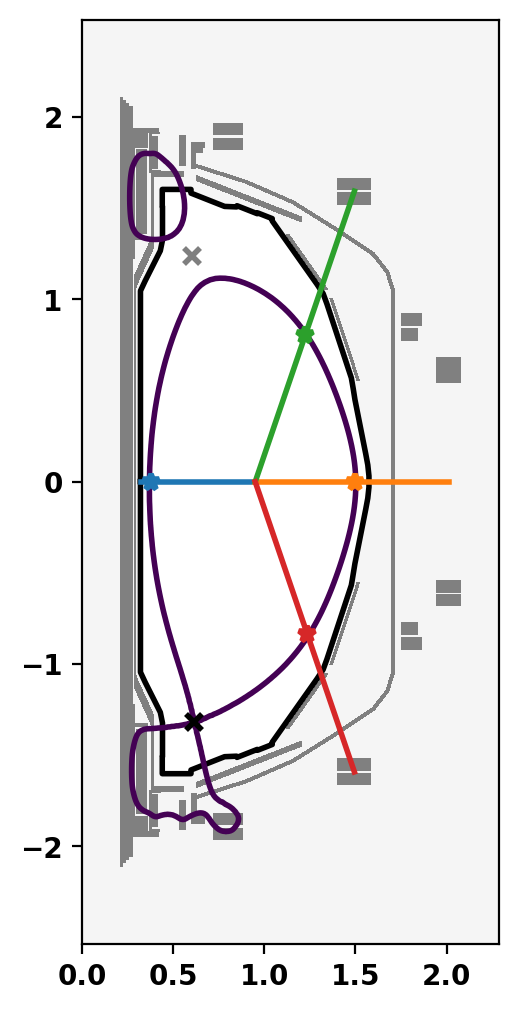

In [32]:
# Plot everything
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,opoint_marker='none',vacuum_nlevels=0,plasma_nlevels=1)
ax.plot(SEG1_R, SEG1_Z)
ax.plot(SEG2_R, SEG2_Z)
ax.plot(SEG3_R, SEG3_Z)
ax.plot(SEG4_R, SEG4_Z)
plt.gca().set_prop_cycle(None)
ax.plot(CP1[0], CP1[1], '*')
ax.plot(CP2[0], CP2[1], '*')
ax.plot(CP3[0], CP3[1], '*')
ax.plot(CP4[0], CP4[1], '*')
plt.show()

In [33]:
print('x-points:', f"[{mygs.x_points[0][0]:.3f},", f"{mygs.x_points[0][1]:.3f}]", f"[{mygs.x_points[1][0]:.3f},", f"{mygs.x_points[1][1]:.3f}]")
print('Control Point 1: ', f"[{CP1[0]:.3f},", f"{CP1[1]:.3f}]")
print('Control Point 2: ', f"[{CP2[0]:.3f},", f"{CP2[1]:.3f}]")
print('Control Point 3: ', f"[{CP3[0]:.3f},", f"{CP3[1]:.3f}]")
print('Control Point 4: ', f"[{CP4[0]:.3f},", f"{CP4[1]:.3f}]")

x-points: [0.603, 1.235] [0.615, -1.322]
Control Point 1:  [0.376, 0.000]
Control Point 2:  [1.497, 0.000]
Control Point 3:  [1.225, 0.804]
Control Point 4:  [1.236, -0.837]
